In [1]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from enum import Enum

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.stats import spearmanr

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))

import utils
import plotting_utils
import climate_utils
import stats
import time_of_emrgence_calc as toe

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

Matplotlib created a temporary config/cache directory at /jobfs/112923455.gadi-pbs/matplotlib-h37pf4ih because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
# Scale the client to have n workers workers
# client.cluster.scale(28)
client

 - State start
 -   Scheduler at:     tcp://127.0.0.1:37133
 -   dashboard at:         /proxy/8787/status
 - Registering Worker plugin shuffle
 -         Start Nanny at: 'tcp://127.0.0.1:43737'
 -         Start Nanny at: 'tcp://127.0.0.1:34717'
 -         Start Nanny at: 'tcp://127.0.0.1:44775'
 -         Start Nanny at: 'tcp://127.0.0.1:42483'
 -         Start Nanny at: 'tcp://127.0.0.1:34317'
 -         Start Nanny at: 'tcp://127.0.0.1:44313'
 -         Start Nanny at: 'tcp://127.0.0.1:39639'
 -         Start Nanny at: 'tcp://127.0.0.1:37563'
 -         Start Nanny at: 'tcp://127.0.0.1:32919'
 -         Start Nanny at: 'tcp://127.0.0.1:46813'
 -         Start Nanny at: 'tcp://127.0.0.1:40569'
 -         Start Nanny at: 'tcp://127.0.0.1:41331'
 -         Start Nanny at: 'tcp://127.0.0.1:39387'
 -         Start Nanny at: 'tcp://127.0.0.1:40915'
 -         Start Nanny at: 'tcp://127.0.0.1:39643'
 -         Start Nanny at: 'tcp://127.0.0.1:44733'
 -         Start Nanny at: 'tcp://127.0.0

<Client: 'tcp://127.0.0.1:37133' processes=28 threads=28, memory=251.18 GiB>

In [3]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

In [4]:
ROOT_DIR = '/g/data/w40/ab2313/PhD/time_of_emergence'
os.listdir(os.path.join(ROOT_DIR, 'best'))

['Land_and_Ocean_LatLong1_time_chunk.zarr',
 'Land_and_Ocean_LatLong1.zarr',
 'Land_and_Ocean_LatLong1.nc',
 '.ipynb_checkpoints']

In [5]:
# chunk_size = {'time': len(best_ds.time.values), 'lat':90, 'lon': 120}  # Chunking in time
# best_ds = best_ds.rename({'latitude':'lat', 'longitude': 'lon|'})
# best_ds = best_ds.chunk(chunk_size)

# best_ds.to_zarr(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1_time_chunk.zarr'), mode='w',
#            encoding={'temperature': {'chunks': (chunk_size['time'], chunk_size['lat'], chunk_size['lon'])}})

In [6]:
best_ds = xr.open_dataset(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1_time_chunk.zarr'), 
                    chunks={'time':-1, 'latitude': 90, 'longitude': 120},
                    use_cftime=True)['temperature']

best_ds['time'] = xr.cftime_range(start='1850-01-01', freq='M', periods=len(best_ds.time.values))
best_ds = best_ds.resample(time='Y').mean()
best_ds = best_ds.compute()

0.3.0


In [7]:
# Create a data set for the base period used as the pre-industrial climate 
start_end_tuple = (1850, 1900)#(1900, 1931)

base_period_ds = best_ds.where(best_ds.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50, lat: 180, lon: 360)>
array([[[  nan, ...,   nan],
        ...,
        [  nan, ...,   nan]],

       ...,

       [[  nan, ...,   nan],
        ...,
        [-0.03, ..., -0.03]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00
Attributes: (5)

In [8]:
base_period_ds_count = base_period_ds.count(dim='time')

In [9]:
# Create a mask that removes any grid celss where there are less than 40 point in the base period
data_availability_mask = xr.where(base_period_ds_count>=40, 1, 0)
data_availability_mask

<xarray.DataArray 'temperature' (lat: 180, lon: 360)>
array([[0, ..., 0],
       ...,
       [0, ..., 0]])
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

In [10]:
# Apply the mask to both the base period and the full dataset
best_ds = best_ds.where(data_availability_mask)
base_period_ds = base_period_ds.where(data_availability_mask)

In [11]:
best_ds = best_ds - base_period_ds.mean(dim='time')

In [12]:
base_period_ds = base_period_ds - base_period_ds.mean(dim='time')

# P-value Methods

1d Array Method <br>

This method comapes starting from the begging and looops through. The nans are added to the end so the length matches

In [103]:
# P-value methods works better with a large cluster.
# Small chunks with large computation
client.cluster.scale(28)

 -         Start Nanny at: 'tcp://127.0.0.1:34389'
 -         Start Nanny at: 'tcp://127.0.0.1:45563'
 -         Start Nanny at: 'tcp://127.0.0.1:45127'
 -         Start Nanny at: 'tcp://127.0.0.1:34329'
 -         Start Nanny at: 'tcp://127.0.0.1:38859'
 -         Start Nanny at: 'tcp://127.0.0.1:37499'
 -         Start Nanny at: 'tcp://127.0.0.1:43391'
 -         Start Nanny at: 'tcp://127.0.0.1:46031'
 -         Start Nanny at: 'tcp://127.0.0.1:40049'
 -         Start Nanny at: 'tcp://127.0.0.1:44505'
 -         Start Nanny at: 'tcp://127.0.0.1:42053'
 -         Start Nanny at: 'tcp://127.0.0.1:32899'
 -         Start Nanny at: 'tcp://127.0.0.1:40333'
 -         Start Nanny at: 'tcp://127.0.0.1:36669'
 -         Start Nanny at: 'tcp://127.0.0.1:36781'
 -         Start Nanny at: 'tcp://127.0.0.1:37621'
 -         Start Nanny at: 'tcp://127.0.0.1:44857'
 -         Start Nanny at: 'tcp://127.0.0.1:42089'
 -         Start Nanny at: 'tcp://127.0.0.1:38107'
 -         Start Nanny at: 'tcp

In [14]:
# Try with a belt latittude and longitude
#.sel(lat=slice(-45, -35), lon=slice(135, 160)) # {'lat':5, 'lon':5, 'time':-1}

In [15]:
window = 20

In [16]:
CHUNKS_FOR_toe_const.PVALUE_TESTS =  {'lat':30, 'lon':30, 'time':-1}

In [17]:
# Creting new datasets that has windown dimnsion for the rolling calculation
best_ds_window = (best_ds
                  .chunk(CHUNKS_FOR_toe_const.PVALUE_TESTS)
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  .persist()) 

base_period_window_ds = (base_period_ds
                         .chunk(CHUNKS_FOR_toe_const.PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist())

In [18]:
best_ds_window

<xarray.DataArray 'temperature' (time: 175, lat: 180, lon: 360, window_dim: 20)>
dask.array<sliding_window_view, shape=(175, 180, 360, 20), dtype=float32, chunksize=(174, 30, 30, 20), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
Dimensions without coordinates: window_dim

In [19]:
base_period_window_ds

<xarray.DataArray 'temperature' (window_dim: 50, lat: 180, lon: 360)>
dask.array<xarray-<this-array>, shape=(50, 180, 360), dtype=float32, chunksize=(50, 30, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat         (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon         (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * window_dim  (window_dim) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00

In [20]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [21]:
%%time
ttest_ds = xr.apply_ufunc(
        toe.return_ttest_pvalue,
        best_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 1min 46s, sys: 16.1 s, total: 2min 2s
Wall time: 7min 7s


In [22]:
ttest_ds.name = 'ttest'

In [24]:
%%time
ks_ds = xr.apply_ufunc(
        toe.return_ks_pvalue,
        best_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 15.1 s, sys: 2.11 s, total: 17.2 s
Wall time: 56.4 s


In [25]:
# ks_2samp will perfom on all nan slices
ks_ds = ks_ds.where(data_availability_mask)

In [26]:
ks_ds.name = 'ks'

In [105]:
warnings.filterwarnings('ignore', message="p-value floored: true value smaller than 0.001")
anderson_ds = xr.apply_ufunc(
    toe.return_anderson_pvalue,
    best_ds_window,
    base_period_window_ds,
    output_dtypes=float, 
    **rolling_window_kwargs
    ).compute()

In [27]:
# anderson_ds = ks_ds.copy(deep=True)

In [106]:
anderson_ds.name = 'anderson'

## Verification that method works
Verifyting the abstracted (but faster) methods works by comparing to a single lat, lon point.

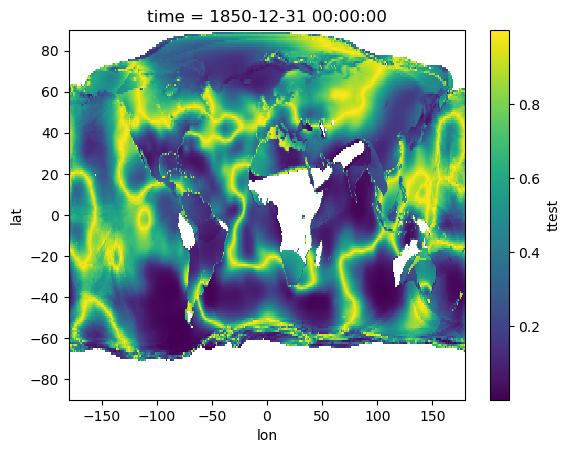

In [23]:
ttest_ds.isel(time=0).plot()

In [29]:
lat_lon_sp = dict(lat=-39, lon=145, method='nearest')

In [30]:
stats_test_1d_array_ttest = partial(
    toe.stats_test_1d_array, stats_func=toe.return_ttest_pvalue, window=window)

stats_test_1d_array_ks = partial(
    toe.stats_test_1d_array, stats_func=toe.return_ks_pvalue, window=window)

In [31]:
ttest_1d_1p = stats_test_1d_array_ttest(best_ds.sel(**lat_lon_sp))

In [32]:
ks_1d_1p = stats_test_1d_array_ks(best_ds.sel(**lat_lon_sp))

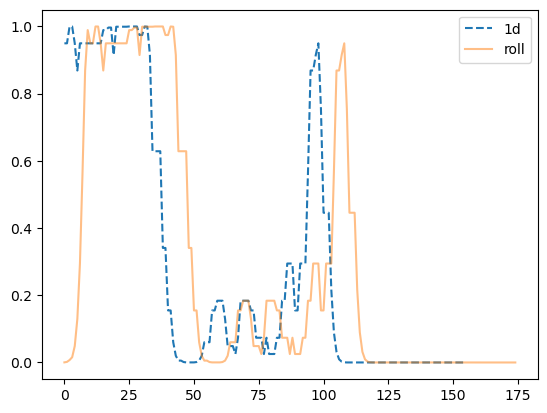

In [33]:
plt.plot(ks_1d_1p,label='1d', linestyle='--')
plt.plot(ks_ds.sel(**lat_lon_sp).values, label='roll', alpha=0.5)
plt.legend()

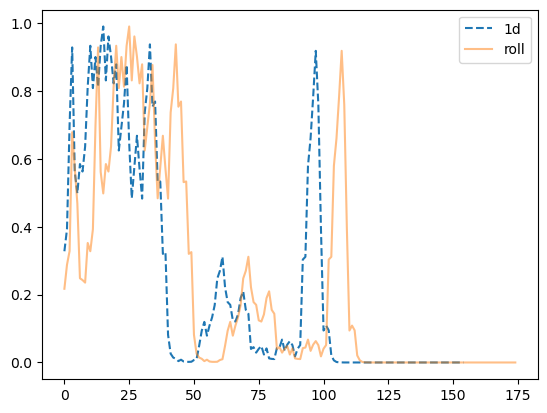

In [34]:
plt.plot(ttest_1d_1p,label='1d', linestyle='--')
plt.plot(ttest_ds.sel(**lat_lon_sp).values, label='roll', alpha=0.5)
plt.legend()

In [96]:
stats_test_1d_array_anderson = partial(
    toe.stats_test_1d_array, stats_func=toe.return_anderson_pvalue, window=window)

In [97]:
anderson_1d_1p = stats_test_1d_array_anderson(best_ds.sel(**lat_lon_sp))

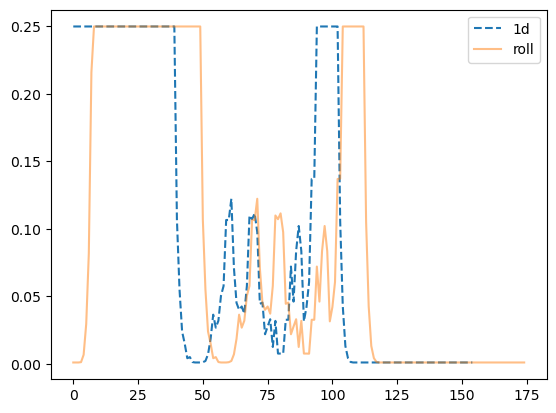

In [107]:
plt.plot(anderson_1d_1p, label='1d', linestyle='--')
plt.plot(anderson_ds.sel(**lat_lon_sp).values, label='roll', alpha=0.5)
plt.legend()

# Signal-to-Noise (hawkins)

In [115]:
# This amount of workers is no longer need
client.cluster.scale(5)

 - Closing Nanny at 'tcp://127.0.0.1:38859'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:37499'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:43391'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:46031'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:40049'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:44505'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:42053'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:32899'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:40333'. Reason: nan

In [36]:
# Calculate the wegithed mean
best_ds_smean = climate_utils.weighted_lat_lon_mean(best_ds)
best_ds_smean

 - Closing Nanny at 'tcp://127.0.0.1:44313'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:39639'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:37563'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:32919'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:46813'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:40569'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:41331'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:39387'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:40915'. Reason: nan

<xarray.DataArray 'temperature' (time: 175)>
array([-0.08, -0.01,  0.04,  0.02,  0.01,  0.03, -0.09, -0.21, -0.04,
        0.08, -0.07, -0.15, -0.22, -0.07, -0.02,  0.06,  0.1 ,  0.12,
        0.11,  0.04,  0.01, -0.  ,  0.02,  0.05, -0.04, -0.02, -0.03,
        0.34,  0.4 ,  0.09,  0.02,  0.12,  0.08,  0.01, -0.14, -0.12,
       -0.15, -0.17,  0.01,  0.13, -0.14,  0.  , -0.09, -0.08, -0.07,
        0.  ,  0.11,  0.09, -0.12,  0.04,  0.15,  0.07, -0.09, -0.18,
       -0.23, -0.04,  0.04, -0.11, -0.16, -0.23, -0.18, -0.2 , -0.12,
       -0.1 ,  0.06,  0.14, -0.08, -0.23, -0.05, -0.04,  0.07,  0.1 ,
        0.01,  0.05,  0.03,  0.09,  0.21,  0.1 ,  0.11, -0.06,  0.17,
        0.21,  0.17, -0.02,  0.13,  0.08,  0.14,  0.29,  0.29,  0.3 ,
        0.35,  0.31,  0.33,  0.4 ,  0.51,  0.38,  0.21,  0.25,  0.2 ,
        0.19,  0.12,  0.29,  0.36,  0.44,  0.24,  0.16,  0.09,  0.32,
        0.34,  0.31,  0.29,  0.34,  0.31,  0.33,  0.08,  0.18,  0.22,
        0.24,  0.19,  0.32,  0.26,  0.14,  0.24,  0.39,  0.18,  0.27,
        0.17,  0.49,  0.36,  0.46,  0.53,  0.6 ,  0.42,  0.58,  0.39,
        0.41,  0.46,  0.59,  0.62,  0.55,  0.71,  0.67,  0.5 ,  0.57,
        0.63,  0.76,  0.61,  0.81,  0.93,  0.72,  0.7 ,  0.84,  0.89,
        0.9 ,  0.83,  0.95,  0.92,  0.89,  0.81,  0.91,  1.  ,  0.87,
        0.93,  0.94,  1.02,  1.2 ,  1.28,  1.19,  1.09,  1.22,  1.27,
        1.14,  1.16,  1.47,  1.63], dtype=float32)
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

In [37]:
# Get lowess filtered version
best_ds_smean_lowess = stats.trend_fit(best_ds_smean, method='LOWESS', lowess_window=41)

In [38]:
return_hawkins_signal_and_noise_partial = partial(toe.return_hawkins_signal_and_noise, gt=best_ds_smean_lowess.values)

In [39]:
%%time
ds_best_signal, ds_best_noise_series = xr.apply_ufunc(
    return_hawkins_signal_and_noise_partial,
    best_ds,
    input_core_dims=[['time']], 
    output_core_dims=[['time'], ['time']], 
    dask='parallelized', 
    vectorize=True
)

 - Event loop was unresponsive in Nanny for 3.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 3.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 3.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 4.62s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 5.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 6.01s.  This is often caused by long

In [40]:
ds_best_noise = ds_best_noise_series.std(dim='time')

 - Event loop was unresponsive in Nanny for 7.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 7.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Scheduler for 7.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 7.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 7.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 7.55s.  This is often caused by 

In [41]:
ds_best_sn = ds_best_signal/ds_best_noise

 - Event loop was unresponsive in Nanny for 5.79s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 5.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 5.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 5.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 4.96s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 4.59s.  This is often caused by long

In [42]:
ds_best_sn.name = 'signal_to_noise'

In [ ]:
ds_best_sn.attrs['long_name']

In [43]:
ds_best_sn

<xarray.DataArray 'signal_to_noise' (lat: 180, lon: 360, time: 175)>
array([[[nan, ..., nan],
        ...,
        [nan, ..., nan]],

       ...,

       [[nan, ..., nan],
        ...,
        [nan, ..., nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

## Verification Plots

In [44]:
sel_dict = dict(lat=-38, lon=144, method='nearest')

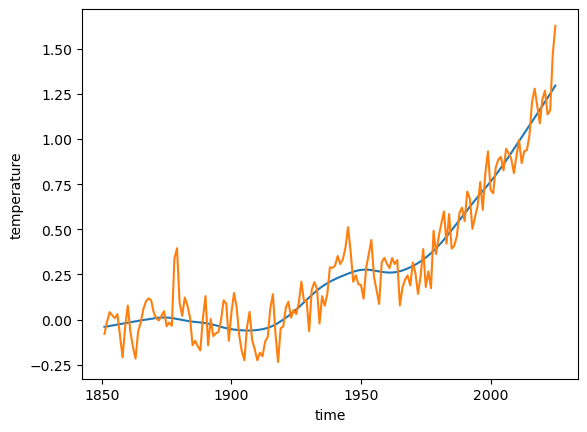

In [45]:
best_ds_smean_lowess.plot()
best_ds_smean.plot()

In [46]:
# Veriftying for a single point
signal_sp, noise_series_sp, reocnstructed_sp =\
    return_hawkins_signal_and_noise_partial(
        best_ds.sel(lat=-14, lon=-115, method='nearest').values,
        return_reconstruction=True)

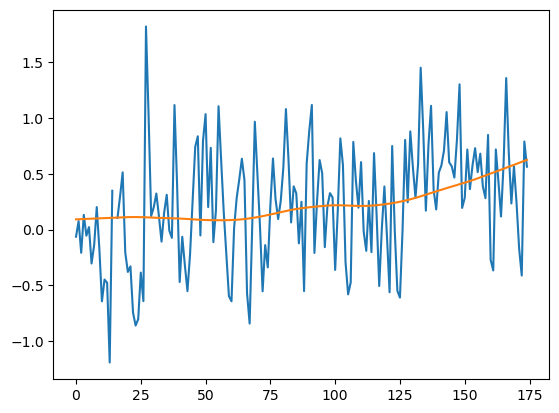

In [47]:
plt.plot(best_ds.sel(lat=-14, lon=-115, method='nearest').values)
plt.plot(reocnstructed_sp)

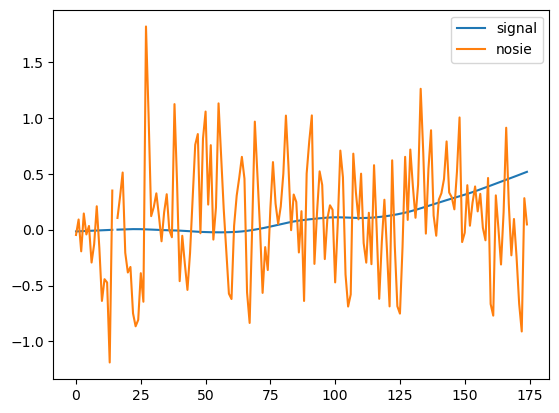

In [48]:
plt.plot(signal_sp, label='signal')
plt.plot(noise_series_sp, label='nosie')
plt.legend()

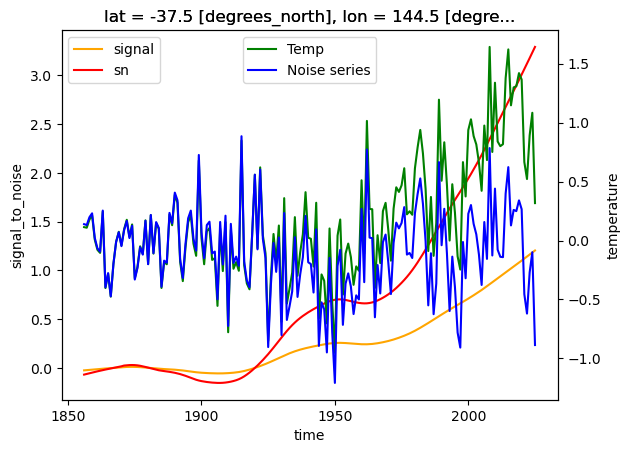

In [49]:
fig, ax1 = plt.subplots(1, 1)
ax2 = ax1.twinx()
ds_best_signal.sel(**sel_dict).plot(ax=ax1, label='signal', color='orange')
ds_best_sn.sel(**sel_dict).plot(ax=ax1, label='sn', color='red')

best_ds.sel(**sel_dict).plot(ax=ax2, label='Temp', color='green')
ds_best_noise_series.sel(**sel_dict).plot(ax=ax2, color='blue', label='Noise series')

ax1.legend()
ax2.legend(loc='upper center')

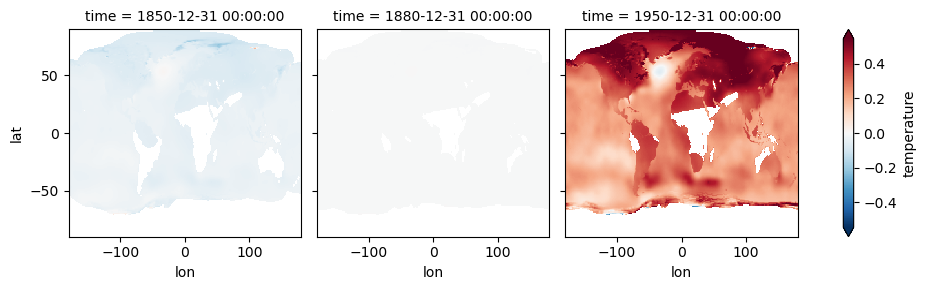

In [50]:
ds_best_signal.isel(time=[0, 30, 100]).plot(col='time', robust=True)

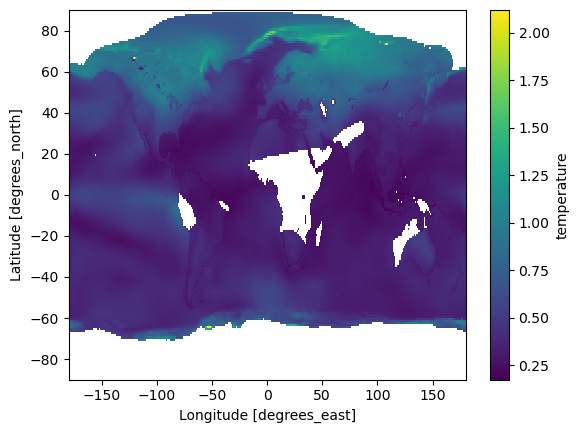

In [51]:
ds_best_noise.plot()

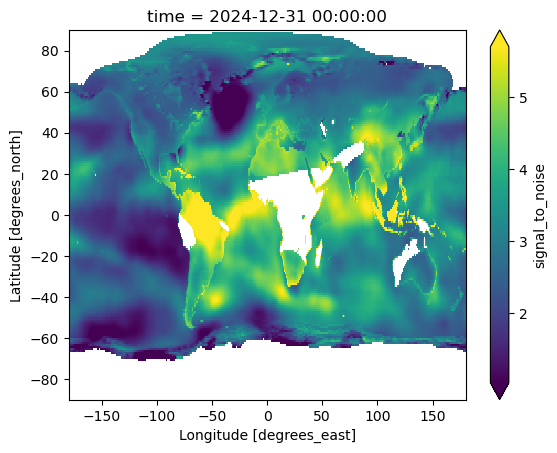

In [52]:
ds_best_sn.isel(time=-1).plot(robust=True)

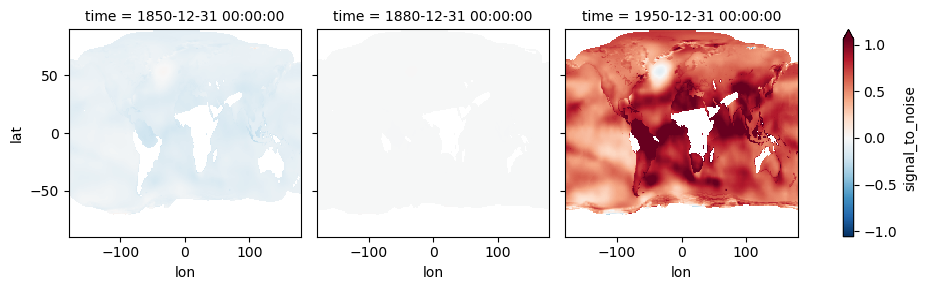

In [53]:
ds_best_sn.isel(time=[0, 30, 100]).plot(col='time', robust=True)

# Emergence Calculation

In [116]:
toe_const.PVALUE_TESTS = ['ks', 'ttest', 'anderson']

In [170]:
# Set long name attributes for each variable
ds_best_sn.attrs['long_name'] = 'Signal to Noise Ratio'
ks_ds.attrs['long_name'] = 'Kolmogorov-Smirnov'
ttest_ds.attrs['long_name'] = 'T-Test'
anderson_ds.attrs['long_name'] = 'Anderson-Darling'

In [171]:
toe_metrics_ds = xr.merge([ks_ds, ttest_ds, anderson_ds, ds_best_sn])
toe_metrics_ds

<xarray.Dataset>
Dimensions:          (lat: 180, lon: 360, time: 175)
Coordinates:
  * lat              (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon              (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time             (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
Data variables:
    ks               (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    ttest            (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    anderson         (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    signal_to_noise  (lat, lon, time) float32 nan nan nan nan ... nan nan nan
Attributes: (1)

In [172]:
PVALUE_THESHOLD1 = 0.01

In [181]:
# Finding when each test does not emerge
sn_does_not_emerge = (toe_metrics_ds['signal_to_noise'].isel(time=-1) <= 2)
ks_does_not_emerge = (toe_metrics_ds['ks'].isel(time=-1) >= PVALUE_THESHOLD1)
ttest_does_not_emerge = (toe_metrics_ds['ttest'].isel(time=-1) >= PVALUE_THESHOLD1)
anderson_does_not_emerge = (toe_metrics_ds['anderson'].isel(time=-1) >= PVALUE_THESHOLD1)

does_not_emerge_ds = xr.merge([sn_does_not_emerge, ks_does_not_emerge,ttest_does_not_emerge , anderson_does_not_emerge])

In [635]:
sn_toe_t2_ds = toe.get_permanent_exceedance(toe_metrics_ds['signal_to_noise'], threshold=2, comparison_func=np.greater_equal).expand_dims(threshold=[2])
sn_toe_t3_ds = toe.get_permanent_exceedance(toe_metrics_ds['signal_to_noise'], threshold=3, comparison_func=np.greater_equal).expand_dims(threshold=[3])
sn_toe_t4_ds = toe.get_permanent_exceedance(toe_metrics_ds['signal_to_noise'], threshold=4, comparison_func=np.greater_equal).expand_dims(threshold=[4])

In [667]:
sn_does_not_emerge_t2 = (toe_metrics_ds['signal_to_noise'].isel(time=-1) <= 2).expand_dims(threshold=[2])
sn_does_not_emerge_t3 = (toe_metrics_ds['signal_to_noise'].isel(time=-1) <= 3).expand_dims(threshold=[3])
sn_does_not_emerge_t4 = (toe_metrics_ds['signal_to_noise'].isel(time=-1) <= 4).expand_dims(threshold=[4])

In [668]:
sn_does_not_emerge_multi_thresh_ds = xr.concat([sn_does_not_emerge_t2, sn_does_not_emerge_t3, sn_does_not_emerge_t4], dim='threshold')

In [636]:
toe_sn_multi_thresh_ds = xr.concat([sn_toe_t2_ds, sn_toe_t3_ds, sn_toe_t4_ds], dim='threshold')

In [187]:
# Find the year of permanent exceedance
sn_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['signal_to_noise'], threshold=2, comparison_func=np.greater_equal)
ks_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['ks'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)
ttest_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['ttest'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)
anderson_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['anderson'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)

toe_ds = xr.merge([sn_toe_ds, ks_toe_ds,ttest_toe_ds , anderson_toe_ds])

In [189]:
# Veryfying merge works
toe_ds['ks'].equals(ks_toe_ds)

True

# Explorign Odd Patterns

In [61]:
time_indices = np.array([0, 50, 100, 150])

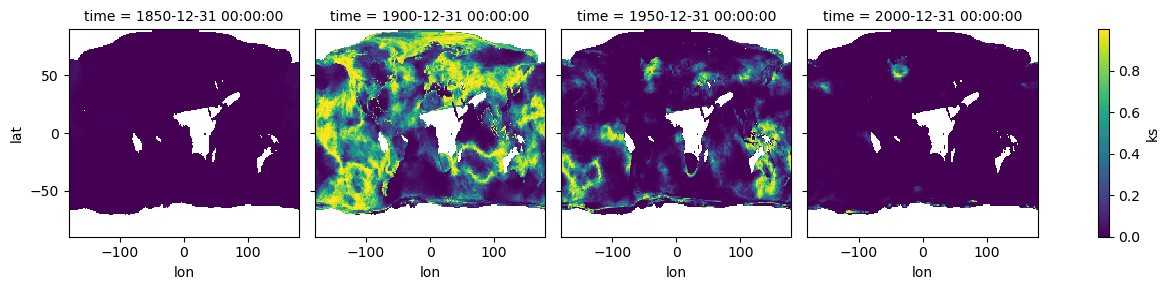

In [62]:
ks_ds.isel(time=time_indices).plot(col='time')

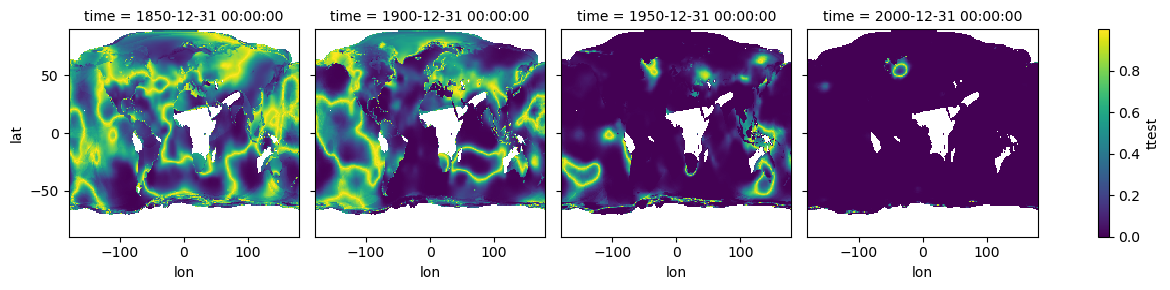

In [63]:
ttest_ds.isel(time=time_indices).plot(col='time')

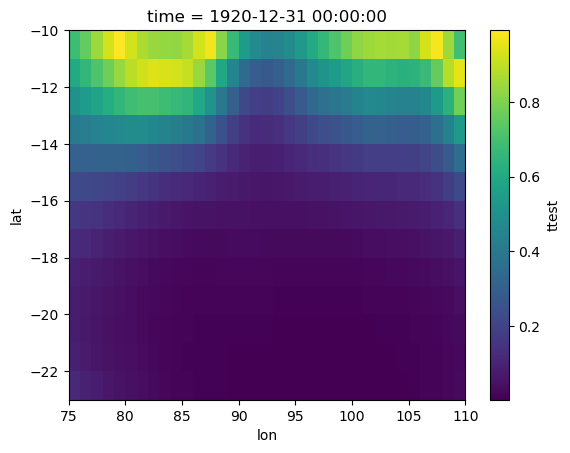

In [64]:
test_sample_ds = ttest_ds.isel(time=70).sel(lat=slice(-22.5, -10), lon=slice(75, 110))
test_sample_ds.plot()

In [65]:
min_lat_lon =\
    utils.find_nth_extreme_location(test_sample_ds, 'min',output_dtype='dict')
min_lat_lon

{'lat': -22.5, 'lon': 98.5}

In [66]:
max_lat_lon =\
    utils.find_nth_extreme_location(test_sample_ds, 'max',output_dtype='dict')
max_lat_lon

{'lat': -10.5, 'lon': 107.5}

In [67]:
min_time_series = best_ds.sel(**min_lat_lon)
max_time_series = best_ds.sel(**max_lat_lon)

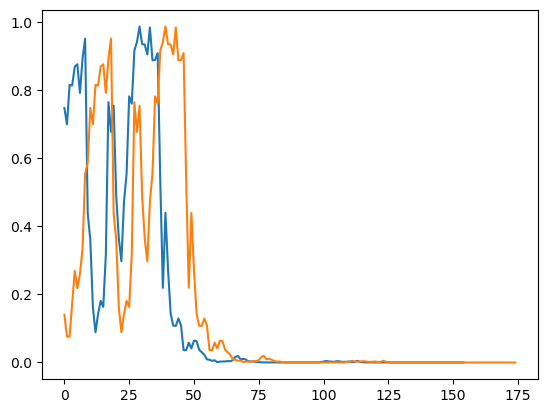

In [68]:
plt.plot(toe.stats_test_1d_array(min_time_series, stats_func=toe.return_ttest_pvalue))
plt.plot(ttest_ds.sel(**min_lat_lon).values)

In [69]:
min_series_pvals = xr.zeros_like(min_time_series) + toe.stats_test_1d_array(min_time_series, stats_func=toe.return_ttest_pvalue)
max_series_pvals = xr.zeros_like(max_time_series) + toe.stats_test_1d_array(max_time_series, stats_func=toe.return_ttest_pvalue)

In [70]:
def color_yaxis(axis, color, side='left'):
    if not isinstance(axis, list): axis = [axis]
    for ax in axis:
        ax.spines[side].set_color(color)
        ax.tick_params(axis='y', color=color, labelcolor=color)

Text(0, 0.5, 'Temperature\nAnomaly')

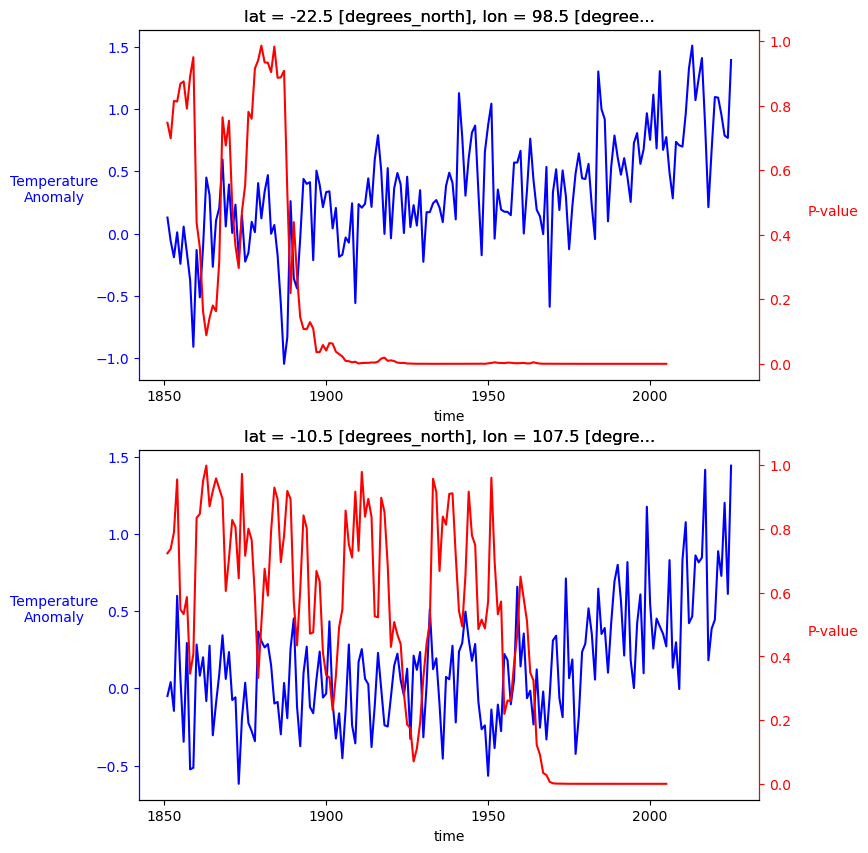

In [71]:
fig, (ax1, ax2) = plt.subplots(figsize=(8, 10), nrows=2, ncols=1)

ax1_twinx = ax1.twinx()
min_time_series.plot(ax=ax1, color='blue')
min_series_pvals.plot(ax=ax1_twinx, color='red')
color_yaxis([ax1, ax1_twinx], 'blue', 'left')
color_yaxis([ax1_twinx], 'red', 'right')
ax1_twinx.set_ylabel('P-value', c='red', rotation=0, labelpad=30)
ax1.set_ylabel('Temperature\nAnomaly', c='blue', rotation=0, labelpad=30)

ax2_twinx = ax2.twinx()
max_time_series.plot(ax=ax2, color='blue')
max_series_pvals.plot(ax=ax2_twinx, color='red')
color_yaxis([ax2, ax2_twinx], 'blue', 'left')
color_yaxis([ax2_twinx], 'red', 'right')
ax2_twinx.set_ylabel('P-value', c='red', rotation=0, labelpad=30)
ax2.set_ylabel('Temperature\nAnomaly', c='blue', rotation=0, labelpad=30)

# Plotting

In [ ]:
import time_of_emergence_plots
import toe_constants as toe_const
import plotting_utils

In [597]:
toe_const.NAME_CONVERSION_DICT

{'signal_to_noise': 'Signal to Noise Ratio',
 'ks': 'Kolmogorov-Smirnov',
 'ttest': 'T-Test',
 'anderson': 'Anderson-Darling'}

In [596]:
long_names = list(toe_const.NAME_CONVERSION_DICT)

## Mask Experimentation

In [120]:
grey_white_cmap = mcolors.LinearSegmentedColormap.from_list('grey_white_cmap',  [(1, 1, 1), (0.5, 0.5, 0.5)] , N=2)

In [121]:
not_stable_kwargs = dict(add_colorbar=False, hatches=['', '////'], alpha=0, colors=None)

not_stable_kwargs2 = dict(cmap= grey_white_cmap, add_colorbar=False)

Text(0.5, 1.0, 'Anderson')

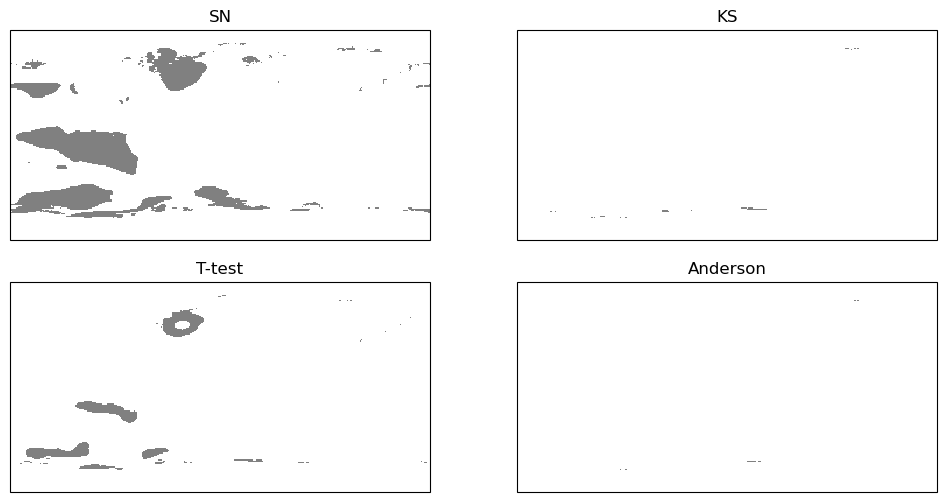

In [178]:
fig = plt.figure(figsize=(12, 6))
axes = [fig.add_subplot(2,2,i, projection=ccrs.PlateCarree()) for i in range(1,5)]

does_not_emerge_ds['signal_to_noise'].plot(ax=axes[0], **not_stable_kwargs2)
does_not_emerge_ds['ks'].plot(ax=axes[1], **not_stable_kwargs2)
does_not_emerge_ds['ttest'].plot(ax=axes[2], **not_stable_kwargs2)
does_not_emerge_ds['anderson'].plot(ax=axes[3], **not_stable_kwargs2)
axes[0].set_title('SN')
axes[1].set_title('KS')
axes[2].set_title('T-test')
axes[3].set_title('Anderson')

In [123]:
def hatch(ax, ds, **kwargs):
    LON, LAT = np.meshgrid(ds.lon.values, ds.lat.values)
    ax.contourf(LON, LAT, ds.values, **kwargs)

In [124]:
not_stable_kwargs = dict(add_colorbar=False, hatches=['', '////'], alpha=0, colors=None)

In [125]:
data_unavailability_mask = xr.where(data_availability_mask, False, True)

## Correlations and Distributions

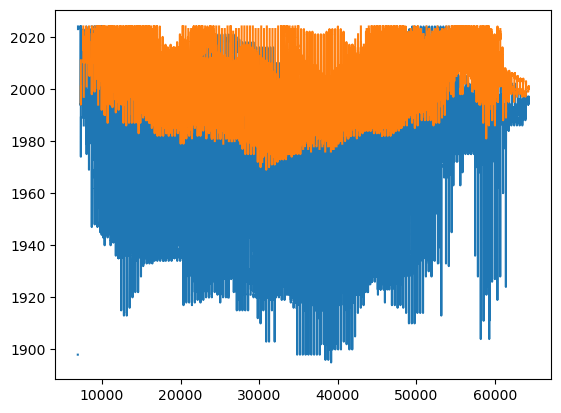

In [126]:
plt.plot(ks_toe_ds.values.flatten())
plt.plot(sn_toe_ds.values.flatten())

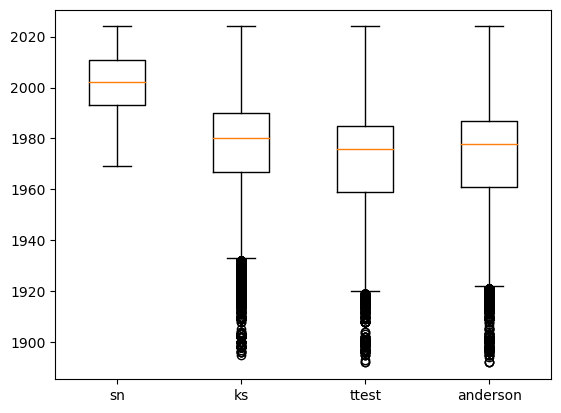

In [147]:
fig, ax = plt.subplots()

bins = np.arange(1900, 2025, 5)
ax.boxplot([toe_ds['signal_to_noise'].stack(latlon=['lat', 'lon']).dropna(dim='latlon').values.flatten(), 
            toe_ds['ks'].stack(latlon=['lat', 'lon']).dropna(dim='latlon').values.flatten(),
            toe_ds['ttest'].stack(latlon=['lat', 'lon']).dropna(dim='latlon').values.flatten(),
            toe_ds['anderson'].stack(latlon=['lat', 'lon']).dropna(dim='latlon').values.flatten()],
          labels=['sn', 'ks', 'ttest', 'anderson']);

In [406]:
test_pattern_correlation_df = toe.data_var_pattern_correlation_all_combs(toe_ds)

In [407]:
test_pattern_correlation_df

signal_to_noise    ks  ttest  anderson
signal_to_noise              NaN   NaN    NaN       NaN
ks                          0.48   NaN    NaN       NaN
ttest                       0.45  0.88    NaN       NaN
anderson                    0.46  0.93   0.93       NaN

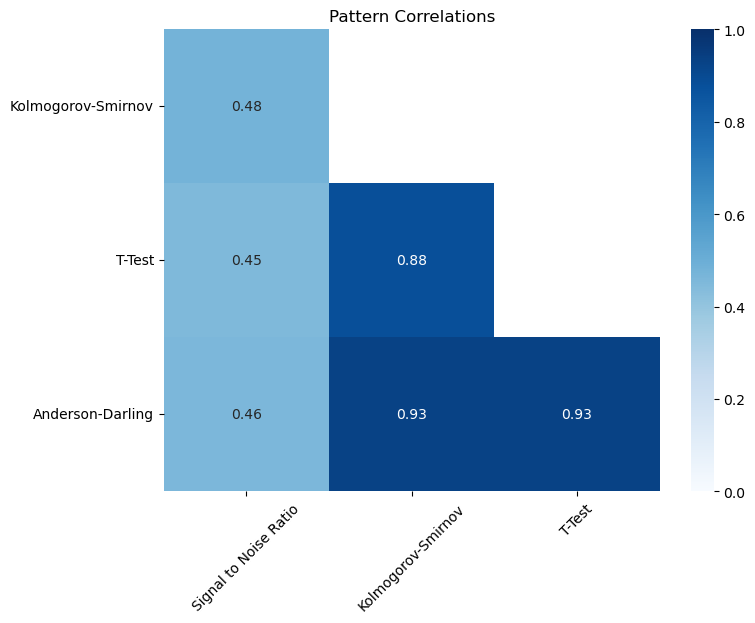

In [427]:
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(test_pattern_correlation_df.iloc[1:, :-1], annot=True, cmap='Blues', fmt='.2f', vmin=0, vmax=1)

# Change the ticks to long names
heatmap.set_xticklabels([toe_const.NAME_CONVERSION_DICT[text.get_text()] for text in heatmap.get_xticklabels()])
heatmap.set_yticklabels([toe_const.NAME_CONVERSION_DICT[text.get_text()] for text in heatmap.get_yticklabels()])

plt.title('Pattern Correlations');
plt.xticks(rotation=45);  # Rotate x-axis labels for better readability
plt.yticks(rotation=0) ;  # Keep y-axis labels horizontal

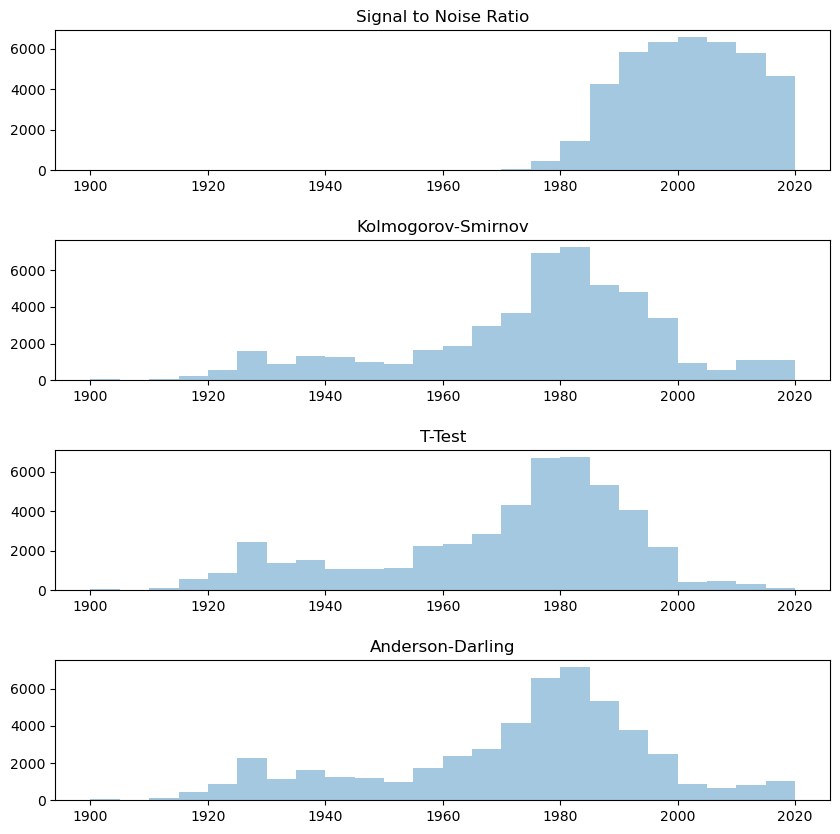

In [195]:
fig = plt.figure(figsize=(10, 10))

gs = gridspec.GridSpec(len(tests_used), 1, hspace=0.5)
axes = [fig.add_subplot(gs[i]) for i in range(len(tests_used))]

bins = np.arange(1900, 2025, 5)
for ax, test in zip(axes, tests_used):
    ax.hist(toe_ds[test].values.flatten(), bins=bins, alpha=0.4)
    ax.set_title(toe_ds[test].long_name)

## Maps

In [82]:
difference_sn_ks_ds = toe_ds['signal_to_noise'] - toe_ds['ks']

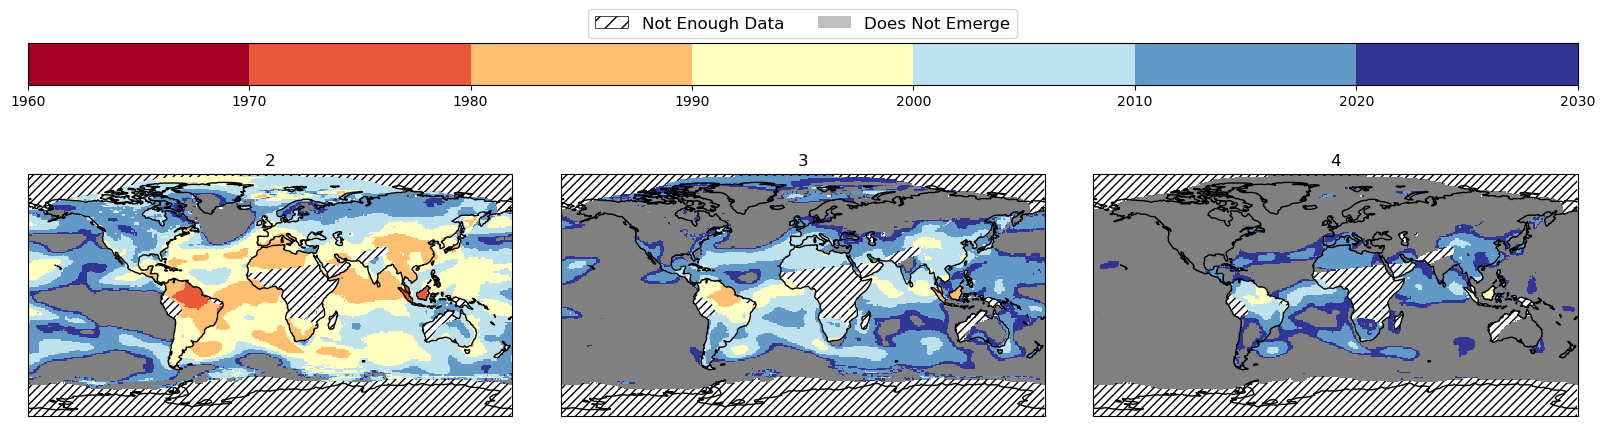

In [672]:
fig = plt.figure(figsize=(20, 6))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[.1, 1], hspace=0, wspace=0.1)
axes = [fig.add_subplot(gs[1, i], projection=projection) for i in range(3)]

not_stable_kwargs2 = dict(cmap= grey_white_cmap, add_colorbar=False)
toe_plot_kwargs = dict(cmap='RdYlBu',add_colorbar=False, levels=np.arange(1960, 2040, 10))# vmin=1890, vmax=2020) #viridis_r

for ax, threshold in zip(axes, toe_sn_multi_thresh_ds.threshold.values):
    sn_does_not_emerge_multi_thresh_ds.sel(threshold=threshold).plot(ax=ax, **not_stable_kwargs2)
    toe_plot = toe_sn_multi_thresh_ds.sel(threshold=threshold).plot(ax=ax, **toe_plot_kwargs)
    ax.set_title(threshold)
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)
    
cbar_axes1 = plt.subplot(gs[0, :])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')

# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 2), fontsize='large', ncol=2)

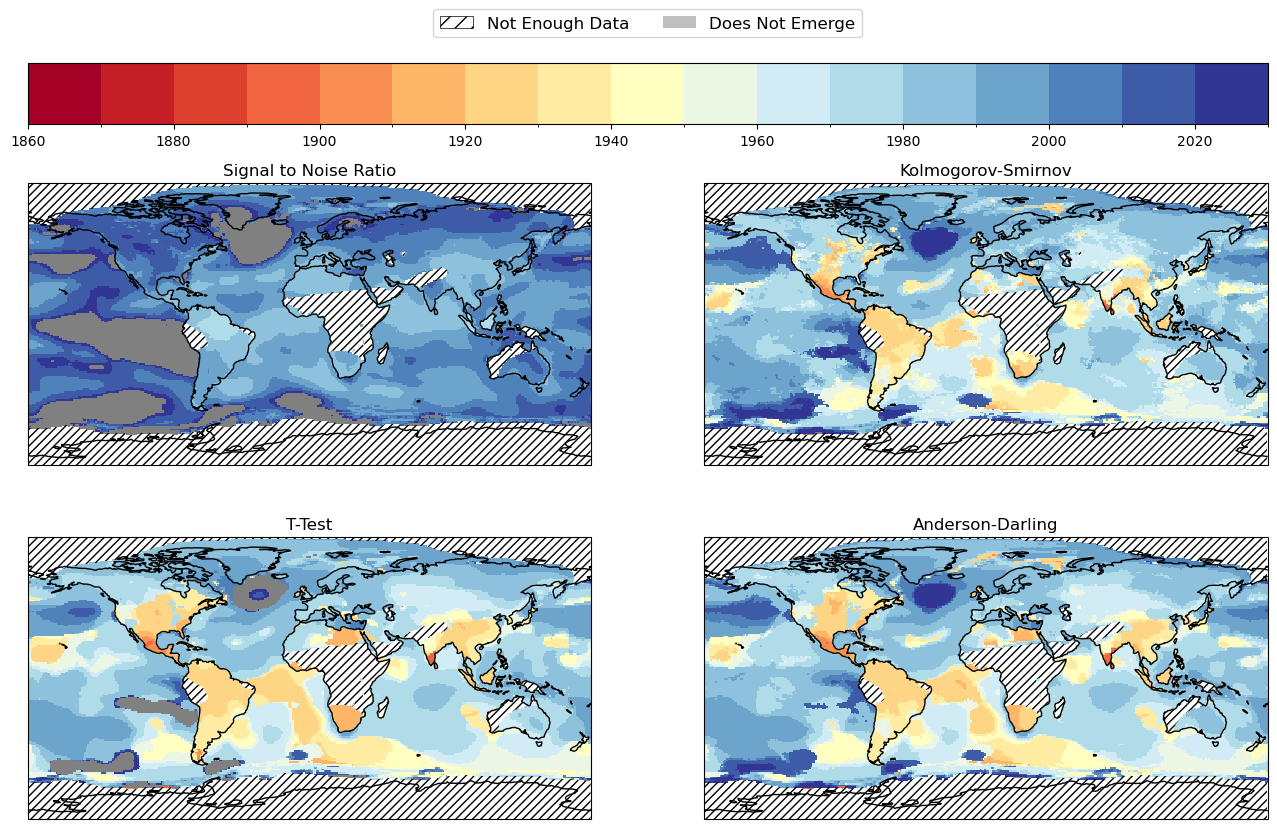

In [243]:
fig = plt.figure(figsize=(16, 10))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[.2, 1, 1], hspace=0.2)
axes = [fig.add_subplot(gs[i], projection=projection) for i in range(2, 6)]

not_stable_kwargs2 = dict(cmap= grey_white_cmap, add_colorbar=False)
toe_plot_kwargs = dict(cmap='RdYlBu',add_colorbar=False, levels=np.arange(1860, 2040, 10))# vmin=1890, vmax=2020) #viridis_r

for ax, test in zip(axes, tests_used):
    does_not_emerge_ds[test].plot(ax=ax, **not_stable_kwargs2)
    toe_plot = toe_ds[test].plot(ax=ax, **toe_plot_kwargs)
    ax.set_title(toe_ds[test].long_name)
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)
    
cbar_axes1 = plt.subplot(gs[0, :])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')

# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 2), fontsize='large', ncol=2)

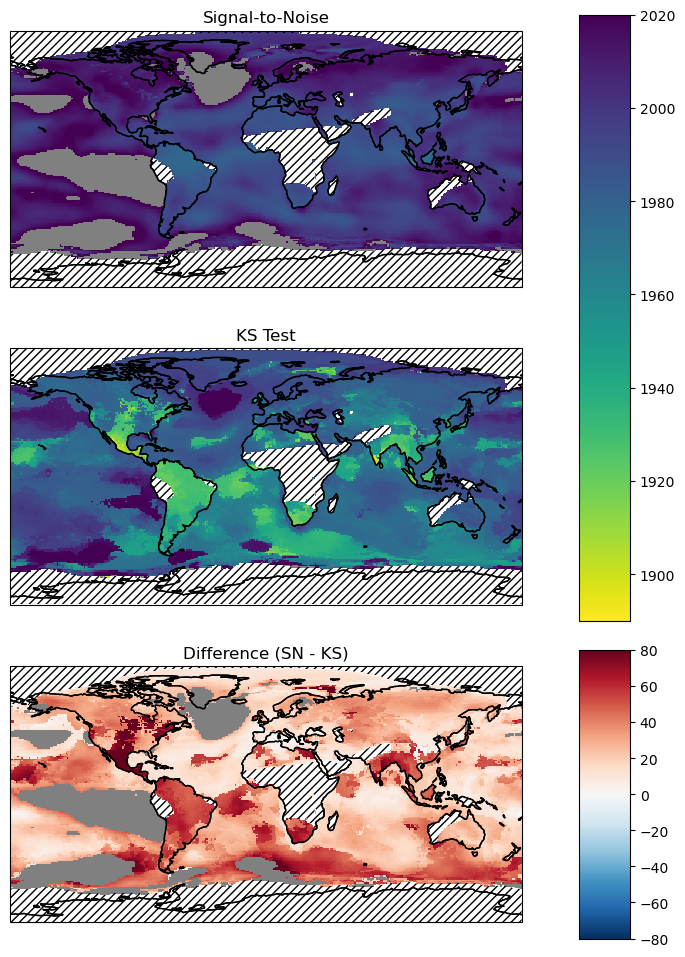

In [83]:
fig = plt.figure(figsize=(8, 12))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(3, 2, width_ratios=[1, 0.1], hspace=0.1)
axes = [fig.add_subplot(gs[i, 0], projection=projection) for i in range(3)]

toe_plot_kwargs = dict(cmap='viridis_r',add_colorbar=False, vmin=1890, vmax=2020)

does_not_emerge_ds['signal_to_noise'].plot(ax=axes[0], **not_stable_kwargs2)
does_not_emerge_ds['ks'].plot(ax=axes[1], **not_stable_kwargs2)
(does_not_emerge_ds['ks'] | does_not_emerge_ds['signal_to_noise']).plot(ax=axes[2], **not_stable_kwargs2)

toe_ds['signal_to_noise'].plot(ax=axes[0], **toe_plot_kwargs)
toe_plot = toe_ds['ks'].plot(ax=axes[1], **toe_plot_kwargs)

cbar_axes1 = plt.subplot(gs[:2, 1])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='vertical')

diff_plot = difference_sn_ks_ds.plot(ax=axes[2], add_colorbar=False, vmin=-80, vmax=80, cmap='RdBu_r')

cbar_axes2 = plt.subplot(gs[2, 1])
cbar2 = plt.colorbar(diff_plot, cax=cbar_axes2, orientation='vertical')

for ax in axes: ax.coastlines()

axes[0].set_title('Signal-to-Noise')
axes[1].set_title('KS Test')
axes[2].set_title('Difference (SN - KS)')

for ax in axes:
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)


## Singla Point Selection Plots

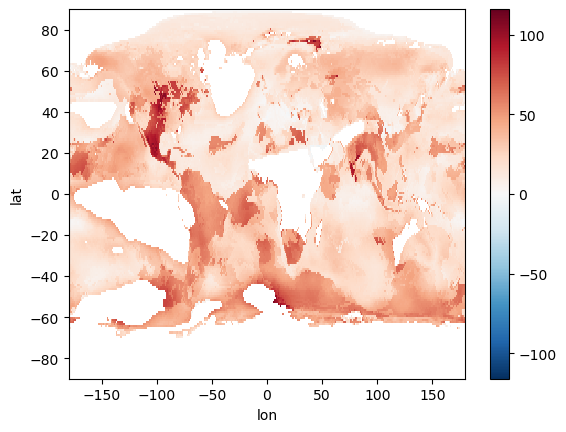

In [428]:
difference_sn_ks_ds.plot()

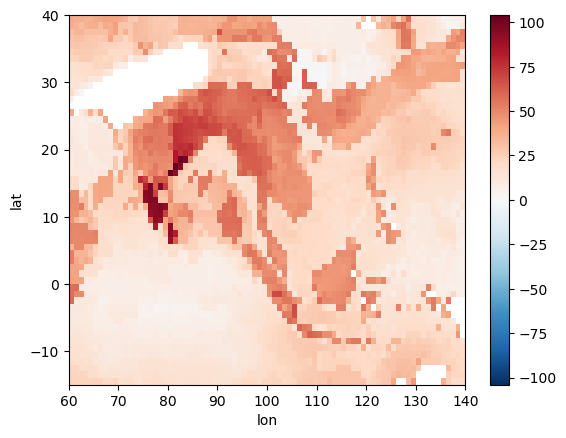

In [610]:
difference_sn_ks_ds.sel(toe_const.LocationBoxes.ASIA.value).plot()

In [613]:
### Asia Targeting

asia_lat_lon_max =\
    utils.find_nth_extreme_location(
        difference_sn_ks_ds.sel(toe_const.LocationBoxes.ASIA.value), 'max',
    output_dtype='dict')

asia_lat_lon_min =\
    utils.find_nth_extreme_location(
        difference_sn_ks_ds.sel(toe_const.LocationBoxes.ASIA.value), 'min',
    output_dtype='dict')

asia_lat_lon_max, asia_lat_lon_min

({'lat': 17.5, 'lon': 81.5}, {'lat': 32.5, 'lon': 107.5})

In [605]:
### North America Targeting

na_lat_lon_max =\
    utils.find_nth_extreme_location(
        difference_sn_ks_ds.sel(toe_const.LocationBoxes.NORTH_AMERICA_LAND_TARGET.value), 'max',
    output_dtype='dict')

na_lat_lon_min ={'lat': 22.5, 'lon': -94.5}

na_lat_lon_max, na_lat_lon_min

({'lat': 46.5, 'lon': -95.5}, {'lat': 22.5, 'lon': -94.5})

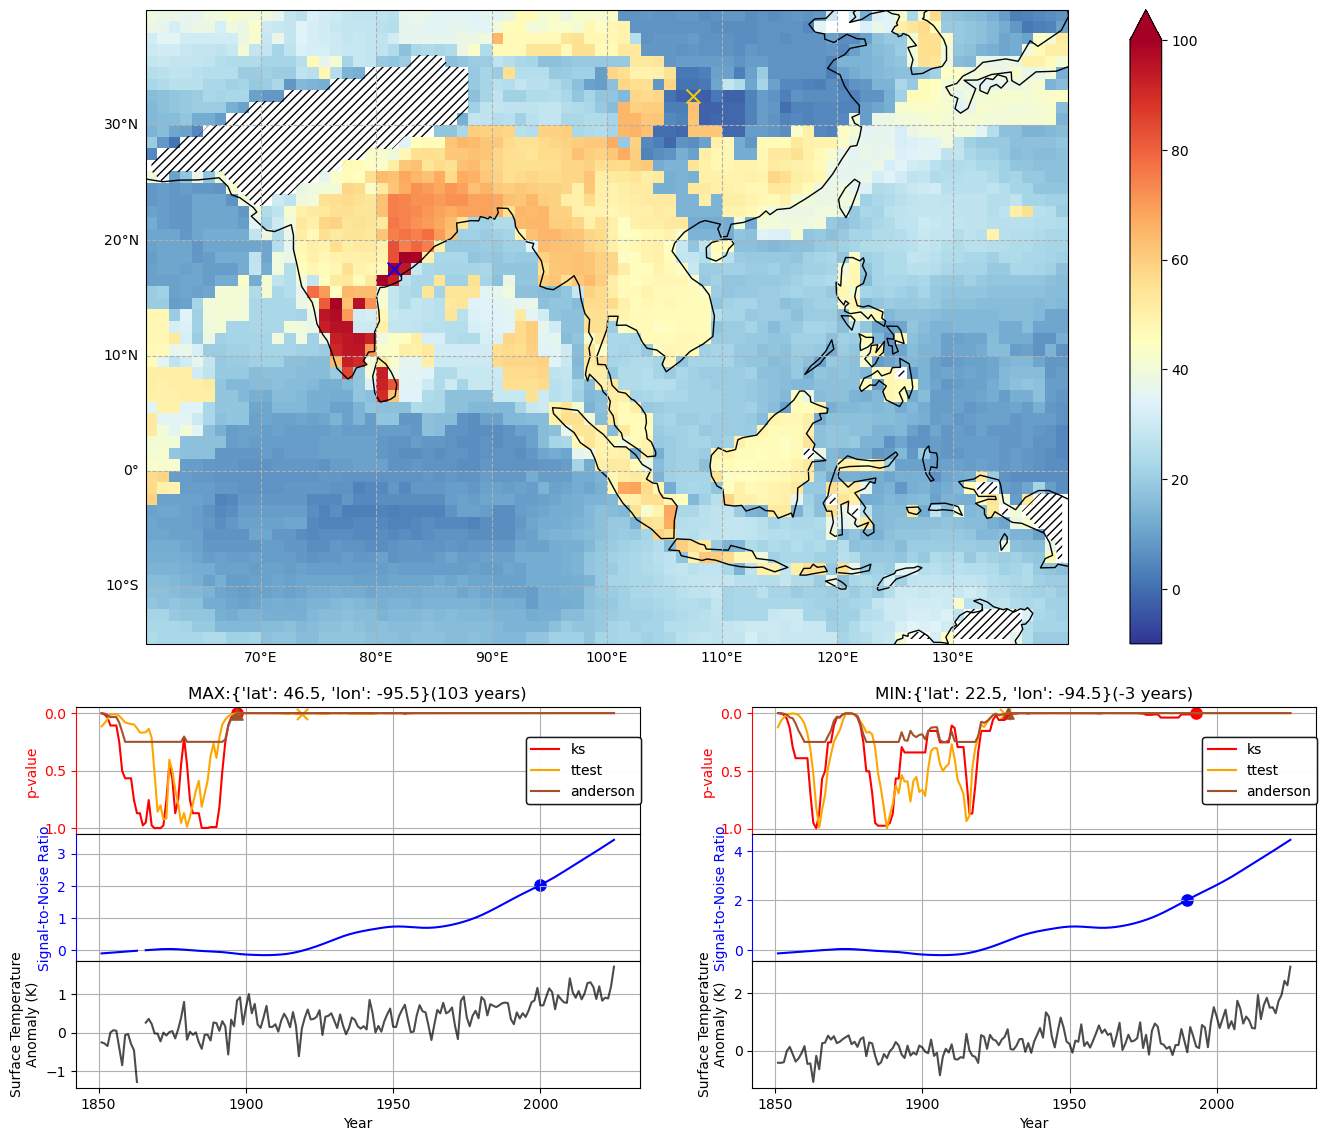

In [628]:
fig = plt.figure(figsize=(16, 14))
gs = gridspec.GridSpec(5, 2, hspace=0, height_ratios = [1, 0.1]+ [0.2]*3) 
ax_top = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree())
axes_left = [fig.add_subplot(gs[i+2, 0]) for i in range(3)]
axes_right = [fig.add_subplot(gs[i+2, 1]) for i in range(3)]

difference_sn_ks_ds.sel(toe_const.LocationBoxes.ASIA.value).plot(ax=ax_top, cmap='RdYlBu_r', vmin=-10, vmax=100)
ax_top.scatter(x=asia_lat_lon_max['lon'], y=asia_lat_lon_max['lat'], marker='x', alpha=.9, s=100, color='blue')
ax_top.scatter(x=asia_lat_lon_min['lon'], y=asia_lat_lon_min['lat'], marker='x', alpha=.9, s=100, color='gold')
hatch(ax_top, data_unavailability_mask.sel(toe_const.LocationBoxes.ASIA.value), **not_stable_kwargs)

plotting_utils.format_lat_lon(ax_top)
ax_top.coastlines()


axes_left[0].set_title('MAX:'+str(na_lat_lon_max) + f'({str(difference_sn_ks_ds.sel(**asia_lat_lon_max).astype(int).values)} years)')
time_of_emergence_plots.plot_multiseries_with_pvalues(toe_metrics_ds.sel(**asia_lat_lon_max, method='nearest'),
                              toe_ds.sel(**asia_lat_lon_max, method='nearest'),
                              best_ds.sel(**asia_lat_lon_max, method='nearest'), 
                             fig=fig, gs=gs, axes=axes_left)


axes_right[0].set_title('MIN:'+str(na_lat_lon_min) + f'({str(difference_sn_ks_ds.sel(**asia_lat_lon_min).astype(int).values)} years)')
time_of_emergence_plots.plot_multiseries_with_pvalues(toe_metrics_ds.sel(**asia_lat_lon_min, method='nearest'),
                              toe_ds.sel(**asia_lat_lon_min, method='nearest'),
                              best_ds.sel(**asia_lat_lon_min, method='nearest'), 
                             fig=fig, gs=gs, axes=axes_right)

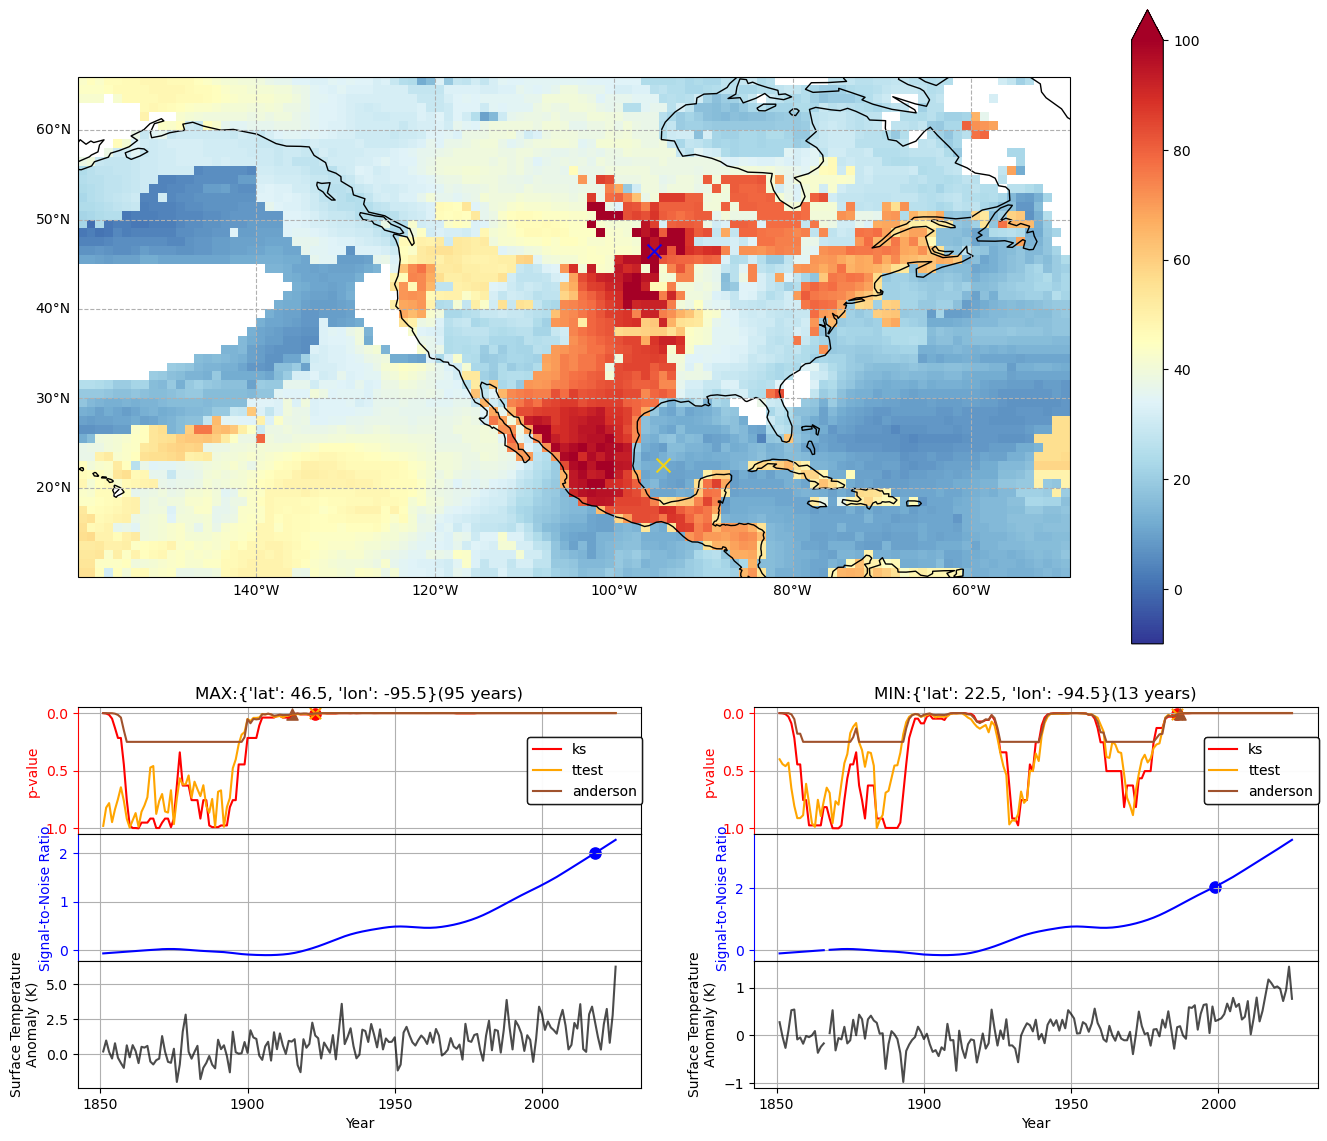

In [629]:
fig = plt.figure(figsize=(16, 14))
gs = gridspec.GridSpec(5, 2, hspace=0, height_ratios = [1, 0.1]+ [0.2]*3) 
ax_top = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree())
axes_left = [fig.add_subplot(gs[i+2, 0]) for i in range(3)]
axes_right = [fig.add_subplot(gs[i+2, 1]) for i in range(3)]

difference_sn_ks_ds.sel(toe_const.LocationBoxes.NORTH_AMERICA.value).plot(ax=ax_top, cmap='RdYlBu_r', vmin=-10, vmax=100)
ax_top.scatter(x=na_lat_lon_max['lon'], y=na_lat_lon_max['lat'], marker='x', alpha=.9, s=100, color='blue')
ax_top.scatter(x=na_lat_lon_min['lon'], y=na_lat_lon_min['lat'], marker='x', alpha=.9, s=100, color='gold')

plotting_utils.format_lat_lon(ax_top)
ax_top.coastlines()
hatch(ax_top, data_unavailability_mask.sel(toe_const.LocationBoxes.NORTH_AMERICA.value), **not_stable_kwargs)
(does_not_emerge_ds['ks'] | does_not_emerge_ds['signal_to_noise']).sel(toe_const.LocationBoxes.NORTH_AMERICA.value).plot(ax=axes[2], **not_stable_kwargs2)


axes_left[0].set_title('MAX:'+str(na_lat_lon_max) + f'({str(difference_sn_ks_ds.sel(**na_lat_lon_max).astype(int).values)} years)')
time_of_emergence_plots.plot_multiseries_with_pvalues(toe_metrics_ds.sel(**na_lat_lon_max, method='nearest'),
                              toe_ds.sel(**na_lat_lon_max, method='nearest'),
                              best_ds.sel(**na_lat_lon_max, method='nearest'), 
                             fig=fig, gs=gs, axes=axes_left)


axes_right[0].set_title('MIN:'+str(na_lat_lon_min) + f'({str(difference_sn_ks_ds.sel(**na_lat_lon_min).astype(int).values)} years)')
time_of_emergence_plots.plot_multiseries_with_pvalues(toe_metrics_ds.sel(**na_lat_lon_min, method='nearest'),
                              toe_ds.sel(**na_lat_lon_min, method='nearest'),
                              best_ds.sel(**na_lat_lon_min, method='nearest'), 
                             fig=fig, gs=gs, axes=axes_right)

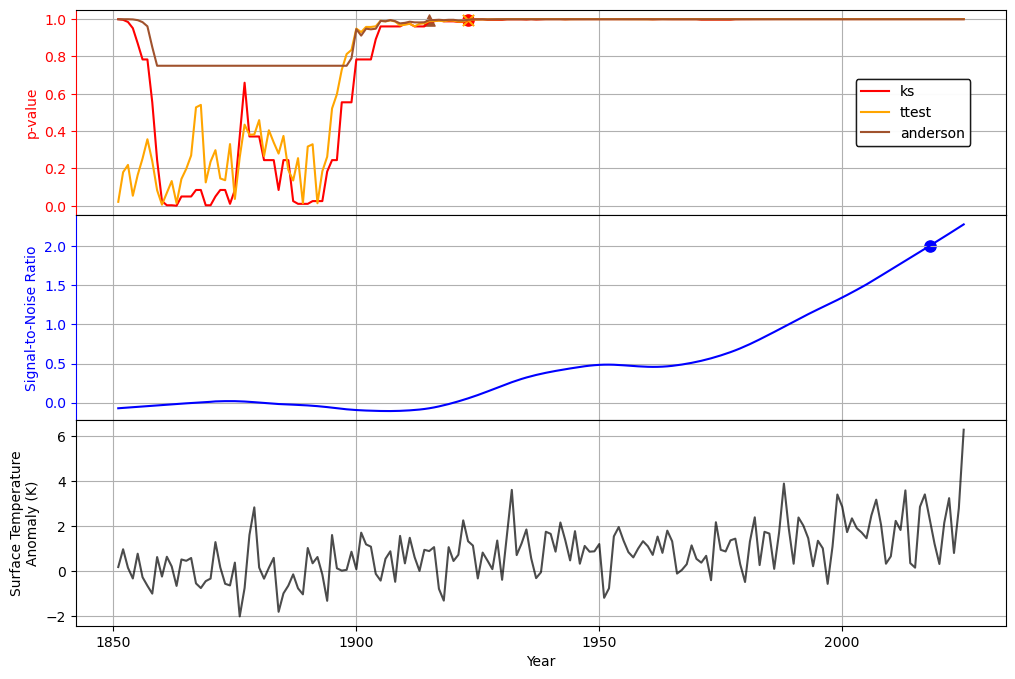

In [502]:
time_of_emergence_plots.plot_multiseries_with_pvalues(toe_metrics_ds.sel(**na_lat_lon, method='nearest'),
                              toe_ds.sel(**na_lat_lon, method='nearest'),
                              best_ds.sel(**na_lat_lon, method='nearest'))

In [491]:
def time_of_emergence_plots.plot_multiseries_with_pvalues_2(
    series_ds: xr.Dataset,
    exceedance_year_ds: xr.Dataset,
    best_ds_smean: xr.Dataset,
    axes
):

    ax1, ax2, ax3 = axes
    legend_lines = []  # For storing lines for the legend

    ax3.plot(best_ds_smean.time.values, best_ds_smean.values, color='black', alpha=0.7)

    time = series_ds.time.values
    for series_name in series_ds.data_vars:
        series_data = series_ds[series_name]
        if series_name in toe_const.PVALUE_TESTS:
            ax = ax1
            series_vals = time_of_emergence_plots.flip_pvalue(series_data.to_numpy())
        elif series_name == 'signal_to_noise':
            ax = ax2
            series_vals = series_data
            
        color = time_of_emergence_plots.TEST_PLOT_DICT[series_name]['color']
        label = series_name
        ax.plot(time, series_vals, c=color, label=label)
        if series_name in toe_const.PVALUE_TESTS: legend_lines.append(ax.plot([], [], color=color, label=label)[0])

    for ax, color in zip([ax1, ax2], ['red', 'blue']):
        ax.spines['left'].set_color(color)
        ax.tick_params(axis='y', color=color, labelcolor=color)

    for test_name in exceedance_year_ds.data_vars:
        # Get the year of exceedance
        year_of_emergence_int = int(exceedance_year_ds[test_name].values)
        # Select the series at the year
        series_year_select = series_ds[test_name].sel(time=series_ds.time.dt.year==year_of_emergence_int)
        # Get the actual time stamp
        year_of_emergence = series_year_select.time.values
        # Get the y-value
        val = float(series_year_select.values)
        if test_name in toe_const.PVALUE_TESTS: val = time_of_emergence_plots.flip_pvalue(val)
        color = time_of_emergence_plots.TEST_PLOT_DICT[test_name]['color']  # Get color from dict or default to black
        ax = ax2 if test_name == 'signal_to_noise' else ax1
        ax.scatter(year_of_emergence, val, color=color, marker=time_of_emergence_plots.TEST_PLOT_DICT[test_name]['marker'], s=65)

    ax1.set_ylabel('p-value', color='red')
    ax2.set_ylabel('Signal-to-Noise Ratio', color='blue')
    ax3.set_ylabel('Surface Temperature\nAnomaly (K)')
    ax3.set_xlabel('Year')

    ax1.grid(True); ax2.grid(True), ax3.grid(True)

    # Create the legend len(legend_lines)
    #legend = ax1.legend(ncol=1, handles=legend_lines, loc='center', bbox_to_anchor=(0.9, 0.5), frameon=True)
    #frame = legend.get_frame()
    #frame.set_color('white')  # Set the legend frame color to white
    #frame.set_edgecolor('black')  # Set the legend frame edge color to black
    # ax1.add_artist(legend)
    #fig.tight_layout()

In [498]:
na_lat_lon2 =\
    utils.find_nth_extreme_location(
        difference_sn_ks_ds.sel(LocationBoxes.NORTH_AMERICA.value), 'max', 2,
    output_dtype='dict')

na_lat_lon3 =\
    utils.find_nth_extreme_location(
        difference_sn_ks_ds.sel(LocationBoxes.NORTH_AMERICA.value), 'min', 1,
    output_dtype='dict')

na_lat_lon4 =\
    utils.find_nth_extreme_location(
        difference_sn_ks_ds.sel(LocationBoxes.NORTH_AMERICA.value), 'min', 2,
    output_dtype='dict')
na_lat_lon2

{'lat': 47.5, 'lon': -102.5}

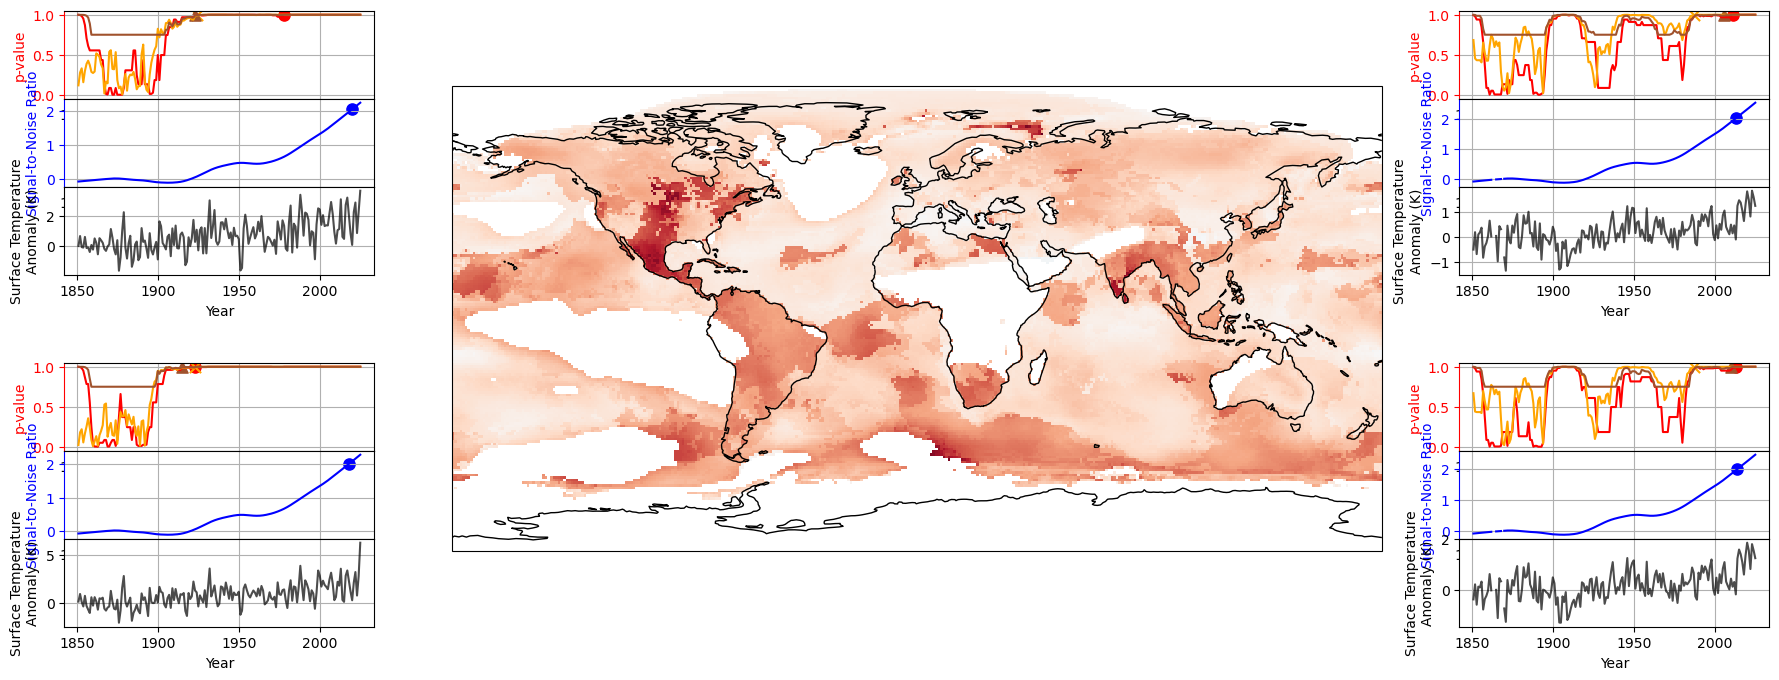

In [499]:
fig = plt.figure(figsize=(22, 8))
gs = gridspec.GridSpec(7, 5, hspace=0, wspace=0, width_ratios=[1, 0.25, 3, 0.25, 1])
ax_center = fig.add_subplot(gs[:, 2], projection=ccrs.PlateCarree())

axes_ll = [fig.add_subplot(gs[i+4, 0]) for i in range(3)]
axes_ul = [fig.add_subplot(gs[i+4, 4]) for i in range(3)]

axes_lr = [fig.add_subplot(gs[i, 0]) for i in range(3)]
axes_ur = [fig.add_subplot(gs[i, 4]) for i in range(3)]


difference_sn_ks_ds.plot(ax=ax_center, add_colorbar=False)
ax_center.coastlines()


time_of_emergence_plots.plot_multiseries_with_pvalues_2(toe_metrics_ds.sel(**na_lat_lon, method='nearest'),
                              toe_ds.sel(**na_lat_lon, method='nearest'),
                              best_ds.sel(**na_lat_lon, method='nearest'), 
                               axes_ll)

time_of_emergence_plots.plot_multiseries_with_pvalues_2(toe_metrics_ds.sel(**na_lat_lon2, method='nearest'),
                              toe_ds.sel(**na_lat_lon2, method='nearest'),
                              best_ds.sel(**na_lat_lon2, method='nearest'), 
                               axes_lr)

time_of_emergence_plots.plot_multiseries_with_pvalues_2(toe_metrics_ds.sel(**na_lat_lon3, method='nearest'),
                              toe_ds.sel(**na_lat_lon3, method='nearest'),
                              best_ds.sel(**na_lat_lon3, method='nearest'), 
                               axes_ul)
time_of_emergence_plots.plot_multiseries_with_pvalues_2(toe_metrics_ds.sel(**na_lat_lon4, method='nearest'),
                              toe_ds.sel(**na_lat_lon4, method='nearest'),
                              best_ds.sel(**na_lat_lon4, method='nearest'), 
                               axes_ur)

In [ ]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(11, 11, hspace=0, wspace=0)
ax_center = fig.add_subplot(gs[4:7, 4:7])
axes_ul = [fig.add_subplot(gs[i, :3]) for i in range(3)]
axes_u = [fig.add_subplot(gs[i, 4:7]) for i in range(3)]
axes_ur = [fig.add_subplot(gs[i, 8:]) for i in range(3)]

axes_l = [fig.add_subplot(gs[i+4, :3]) for i in range(3)]
axes_r = [fig.add_subplot(gs[i+4, 8:]) for i in range(3)]

axes_ll = [fig.add_subplot(gs[i+8, :3]) for i in range(3)]
axes_l = [fig.add_subplot(gs[i+8, 4:7]) for i in range(3)]
axes_lr = [fig.add_subplot(gs[i+8, 8:]) for i in range(3)]

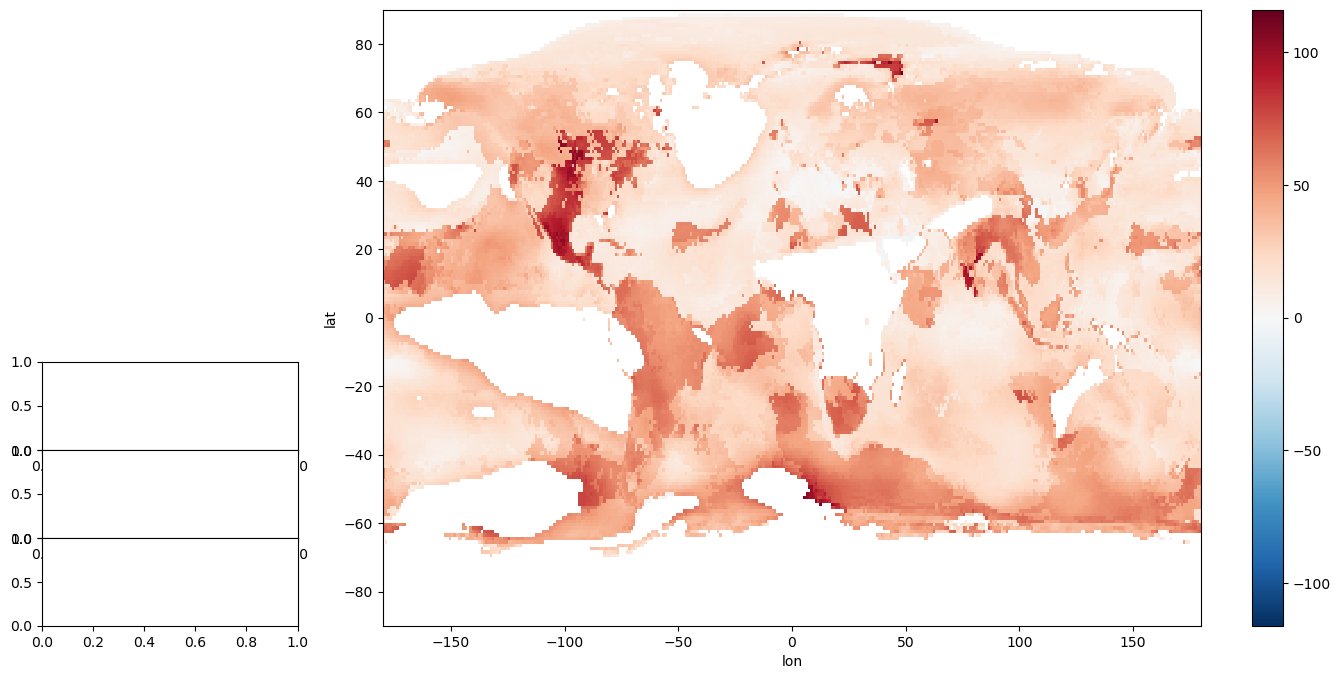

In [475]:
fig = plt.figure(figsize=(22, 8))
gs = gridspec.GridSpec(7, 20, hspace=0, wspace=0, width_ratios=[1, ])
ax_center = fig.add_subplot(gs[:, 4:16])

axes_l = [fig.add_subplot(gs[i+4, :3]) for i in range(3)]

difference_sn_ks_ds.plot(ax=ax_center)

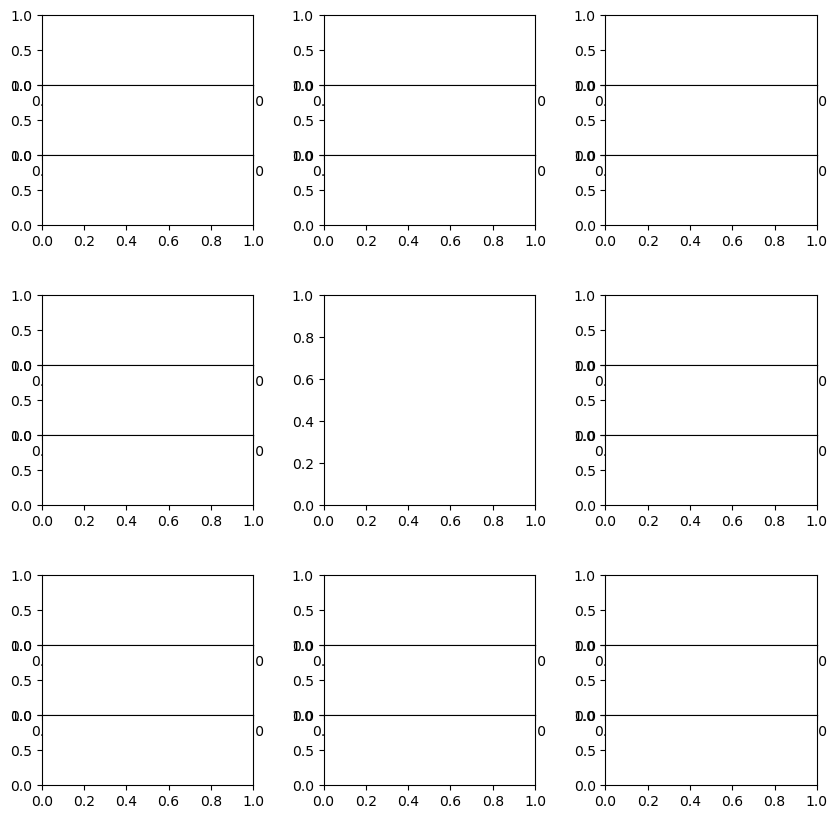

In [461]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(11, 11, hspace=0, wspace=0)
ax_center = fig.add_subplot(gs[4:7, 4:7])
axes_ul = [fig.add_subplot(gs[i, :3]) for i in range(3)]
axes_u = [fig.add_subplot(gs[i, 4:7]) for i in range(3)]
axes_ur = [fig.add_subplot(gs[i, 8:]) for i in range(3)]

axes_l = [fig.add_subplot(gs[i+4, :3]) for i in range(3)]
axes_r = [fig.add_subplot(gs[i+4, 8:]) for i in range(3)]

axes_ll = [fig.add_subplot(gs[i+8, :3]) for i in range(3)]
axes_l = [fig.add_subplot(gs[i+8, 4:7]) for i in range(3)]
axes_lr = [fig.add_subplot(gs[i+8, 8:]) for i in range(3)]

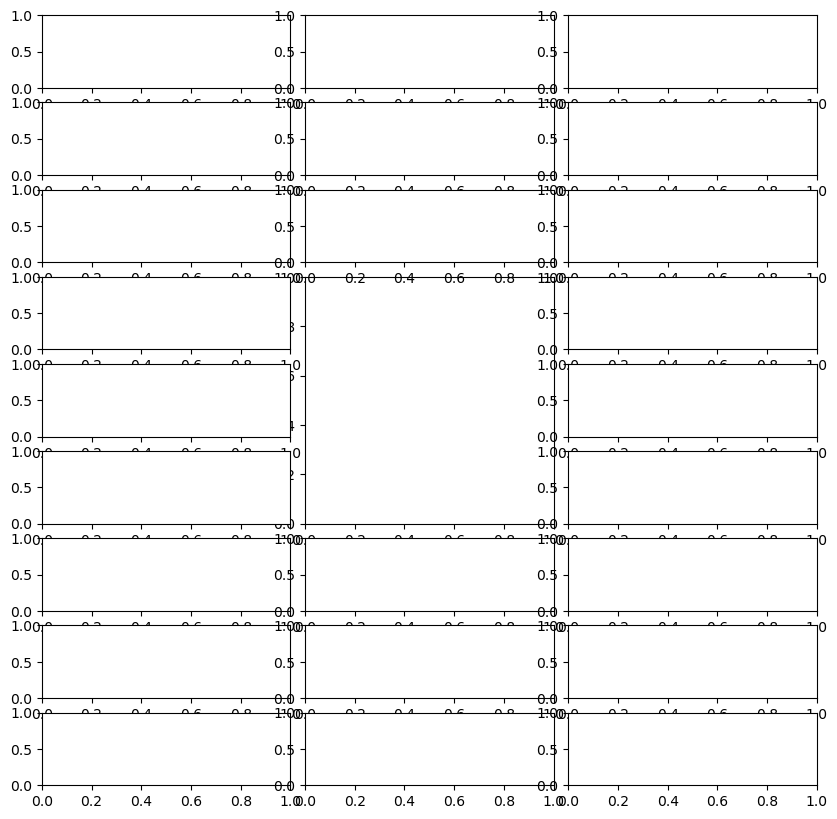

In [453]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(9, 9)
ax_center = fig.add_subplot(gs[3:6, 3:6])
axes_ul = [fig.add_subplot(gs[i, :3]) for i in range(3)]
axes_u = [fig.add_subplot(gs[i, 3:6]) for i in range(3)]
axes_ur = [fig.add_subplot(gs[i, 6:]) for i in range(3)]

axes_l = [fig.add_subplot(gs[i+3, :3]) for i in range(3)]
axes_r = [fig.add_subplot(gs[i+3, 6:]) for i in range(3)]

axes_ll = [fig.add_subplot(gs[i+6, :3]) for i in range(3)]
axes_l = [fig.add_subplot(gs[i+6, 3:6]) for i in range(3)]
axes_lr = [fig.add_subplot(gs[i+6, 6:]) for i in range(3)]

Text(0.5, 1.0, 'Diag Lower Right')

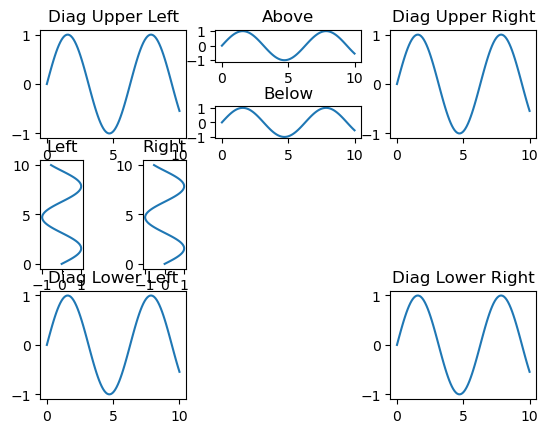

In [435]:


# Create the surrounding plots
gs_side = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs_main[0, 1])
ax_above = plt.subplot(gs_side[0])
ax_above.plot(x, y)
ax_above.set_title('Above')

ax_below = plt.subplot(gs_side[2])
ax_below.plot(x, y)
ax_below.set_title('Below')

gs_side = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_main[1, 0])
ax_left = plt.subplot(gs_side[0])
ax_left.plot(y, x)
ax_left.set_title('Left')

ax_right = plt.subplot(gs_side[2])
ax_right.plot(y, x)
ax_right.set_title('Right')

gs_diag_upper_left = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs_main[0, 0])
ax_diag_upper_left = plt.subplot(gs_diag_upper_left[:, :])
ax_diag_upper_left.plot(x, y)
ax_diag_upper_left.set_title('Diag Upper Left')

gs_diag_upper_right = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs_main[0, 2])
ax_diag_upper_right = plt.subplot(gs_diag_upper_right[:, :])
ax_diag_upper_right.plot(x, y)
ax_diag_upper_right.set_title('Diag Upper Right')

gs_diag_lower_left = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs_main[2, 0])
ax_diag_lower_left = plt.subplot(gs_diag_lower_left[:, :])
ax_diag_lower_left.plot(x, y)
ax_diag_lower_left.set_title('Diag Lower Left')

gs_diag_lower_right = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs_main[2, 2])
ax_diag_lower_right = plt.subplot(gs_diag_lower_right[:, :])
ax_diag_lower_right.plot(x, y)
ax_diag_lower_right.set_title('Diag Lower Right')

In [93]:
# def time_of_emergence_plots.plot_multiseries_with_pvalues(
#     series_ds: xr.Dataset,
#     exceedance_year_ds: xr.Dataset,
#     best_ds_smean: xr.Dataset
# ):
#     fig, ax_base = plt.subplots(figsize=(12, 8))
#     ax1 = ax_base.twinx()  # p-value tests
#     ax2 = ax_base.twinx()  # SN

#     legend_lines = []  # For storing lines for the legend


#     ax_base.plot(best_ds_smean.time.values, best_ds_smean.values, color='black', alpha=0.7)

#     time = series_ds.time.values
#     for series_name in series_ds.data_vars:
#         series_data = series_ds[series_name]
#         if series_name in toe_const.PVALUE_TESTS:
#             ax = ax1
#             series_vals = time_of_emergence_plots.flip_pvalue(series_data.to_numpy())
#         elif series_name == 'signal_to_noise':
#             ax = ax2
#             series_vals = series_data
            
#         color = time_of_emergence_plots.TEST_PLOT_DICT[series_name]['color']
#         label = series_name
#         ax.plot(time, series_vals, c=color, label=label)
#         legend_lines.append(ax.plot([], [], color=color, label=label)[0])

#     for ax, color in zip([ax1, ax2], ['red', 'blue']):
#         ax.spines['right'].set_color(color)
#         ax.tick_params(axis='y', color=color, labelcolor=color)

#     for test_name in exceedance_year_ds.data_vars:
#         # Get the year of exceedance
#         year_of_emergence_int = int(exceedance_year_ds[test_name].values)
#         # Select the series at the year
#         series_year_select = series_ds[test_name].sel(time=series_ds.time.dt.year==year_of_emergence_int)
#         # Get the actual time stamp
#         year_of_emergence = series_year_select.time.values
#         # Get the y-value
#         val = float(series_year_select.values)
#         if test_name in toe_const.PVALUE_TESTS: val = time_of_emergence_plots.flip_pvalue(val)
#         color = time_of_emergence_plots.TEST_PLOT_DICT[test_name]['color']  # Get color from dict or default to black
#         ax = ax2 if test_name == 'signal_to_noise' else ax1
#         ax.scatter(year_of_emergence, val, color=color, marker=time_of_emergence_plots.TEST_PLOT_DICT[test_name]['marker'], s=65)

#     ax1.set_ylim(-0.01, 1.01)
#     ax2.set_ylim(-1, 2.5)
#     ax_base.set_ylim(-3, 10)
    
#     plotting_utils.match_ticks(ax1, ax2, perturb=0.01, logginglevel='ERROR')
#     plotting_utils.match_ticks(ax1, ax_base, perturb=0.01, ax2_round_level=0, logginglevel='DEBUG')
#     ax1.set_yticklabels([label.get_text() for label in ax1.get_yticklabels()][::-1])

#     ax1.set_ylabel('p-value', color='red')
#     ax2.set_ylabel('Signal-to-Noise Ratio', color='blue')

#     ax2.spines['right'].set_position(('outward', 60))

#     # best_ds_smean.plot(ax=ax_base)
#     ax_base.set_ylabel('Surface Temperature Anomaly (K)')

#     ax1.grid(True)
#     ax_base.grid(True, axis='x')

#     # Create the legend
#     legend = ax_base.legend(ncol=len(legend_lines), handles=legend_lines, loc='center', bbox_to_anchor=(0.5, 0.95), frameon=True)
#     frame = legend.get_frame()
#     frame.set_color('white')  # Set the legend frame color to white
#     frame.set_edgecolor('black')  # Set the legend frame edge color to black

#     # Move the legend to the left side
#     ax_base.add_artist(legend)

#     ax_base.set_xlabel('Time')